# Preprocessing

* **After applying initial EDA to our datasets, We'll now target the following preprocessing tasks:**

    * Handle null values and inconsistencies for all features.
    * Create a target variable (issue_happened) reflecting whether
    a problem happened during the transfer of this package/receptacle.
    * Propose, validate assumptions (with Ms.Lasmi), and work based on them.

In [415]:
import pandas as pd

In [416]:
packages_df = pd.read_csv('../data/raw/packages_data_2023_2025.csv', encoding='latin-1', delimiter=';')
receptacles_df = pd.read_csv('../data/raw/receptacle_data_2023_2025.csv', encoding='latin-1', delimiter=';')

* Columns Renaming

In [417]:
packages_df = packages_df.rename(columns={'établissement_postal': 'etablissement_postal', 'next_établissement_postal': 'next_etablissement_postal'})
receptacles_df = receptacles_df.rename(columns={'ï»¿RECPTCL_FID': 'RECPTCL_FID', 'EVENT_TYPECD': 'EVENT_TYPE_CD', 'nextetablissement_postal': 'next_etablissement_postal'})

* `date` type adjustment

In [418]:
packages_df['date'] = pd.to_datetime(packages_df['date'])
receptacles_df['date'] = pd.to_datetime(receptacles_df['date'])
packages_df['RECPTCL_FID'] = packages_df['RECPTCL_FID'].str.strip()
packages_df['MAILITM_FID'] = packages_df['MAILITM_FID'].str.strip()
packages_df['etablissement_postal'] = packages_df['etablissement_postal'].str.strip()
packages_df['next_etablissement_postal'] = packages_df['next_etablissement_postal'].str.strip()
receptacles_df['etablissement_postal'] = receptacles_df['etablissement_postal'].str.strip()
receptacles_df['next_etablissement_postal'] = receptacles_df['next_etablissement_postal'].str.strip()
receptacles_df['RECPTCL_FID'] = receptacles_df['RECPTCL_FID'].str.strip()

In [419]:
packages_df.head()

,RECPTCL_FID,MAILITM_FID,date,etablissement_postal,EVENT_TYPE_CD,next_etablissement_postal
0,USORDADZALGDAUN30050001900005,0000420016941,2023-07-04 05:00:00,NaN,12,ETAB_2389
1,USORDADZALGDAUN30050001900005,0000689914049,2023-07-04 05:00:00,NaN,12,ETAB_2389
2,USORDADZALGDAUN30050001900005,0000700051000,2023-07-04 05:00:00,NaN,12,ETAB_2389
3,USORDADZALGDAUN30102003900026,0031069949200,2023-12-04 05:00:00,NaN,12,ETAB_2389
4,FRCDGADZALGDAUN40553006010061,1A02349441537,2024-12-19 11:05:00,NaN,12,ETAB_2389


In [420]:
packages_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   RECPTCL_FID                1000000 non-null  object        
 1   MAILITM_FID                1000000 non-null  object        
 2   date                       1000000 non-null  datetime64[ns]
 3   etablissement_postal       973228 non-null   object        
 4   EVENT_TYPE_CD              1000000 non-null  int64         
 5   next_etablissement_postal  411733 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 45.8+ MB


In [421]:
receptacles_df.head()

,RECPTCL_FID,date,etablissement_postal,EVENT_TYPE_CD,next_etablissement_postal
0,AEDXBADZAAEDACN45001001100219,2024-07-24 22:40:00.000,ETAB_0001,107,ETAB_0030
1,AEDXBADZAAEDACN45001001100219,2024-07-26 16:18:34.623,ETAB_0002,130,NaN
2,AEDXBADZAAEDACN45001001100219,2024-07-26 16:23:22.207,ETAB_0002,132,ETAB_0003
3,AEDXBADZAAEDACN45001001100219,2024-07-28 13:04:36.387,ETAB_0003,132,ETAB_0033
4,AEDXBADZAAEDACN45002001100075,2024-07-27 22:40:00.000,ETAB_0001,107,ETAB_0030


In [422]:
receptacles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   RECPTCL_FID                1000000 non-null  object        
 1   date                       1000000 non-null  datetime64[ns]
 2   etablissement_postal       998889 non-null   object        
 3   EVENT_TYPE_CD              1000000 non-null  int64         
 4   next_etablissement_postal  576148 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 38.1+ MB


In [423]:
packages_df['etablissement_postal'].isna().sum()

np.int64(26772)

* `etablissement_postal` have 26772 null values (2.7% of the whole dataset)

* As its null values are less than 5% of the dataset (2.7%), we drop these null values

In [424]:
packages_df = packages_df[~packages_df['etablissement_postal'].isna()]
packages_df['etablissement_postal'].isna().sum()

np.int64(0)

* We propose to consider the packages having null `next_etablissement_postal`
as having issue during transfer, we'll try to validate that using
`EVENT_TYPE_CD` also

In [425]:
import matplotlib.pyplot as plt
import seaborn as sns

In [426]:
# packages_df['next_etablissement_postal'] = packages_df['next_etablissement_postal'].fillna('Unknown')
# packages_df['next_etablissement_postal'].isna().any()

* Let's check if `EVENT_TYPE_CD` can indicate whether the `next_etablissement_postal` is null or not

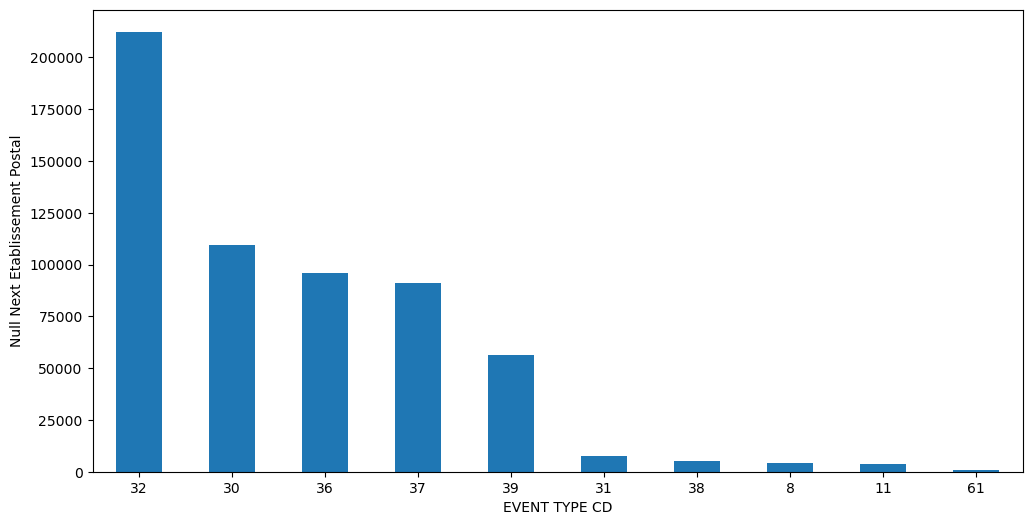

In [427]:
packages_unknown_next_etablissement = packages_df[packages_df['next_etablissement_postal'].isna()]
# keep only top EVENT_TYPES_ID
packages_unknown_next_etablissement = packages_unknown_next_etablissement['EVENT_TYPE_CD'].value_counts()

plt.figure(figsize=(12, 6))
packages_unknown_next_etablissement.head(10).plot(kind='bar')
plt.xlabel('EVENT TYPE CD')
plt.ylabel('Null Next Etablissement Postal')
plt.xticks(rotation=0)
plt.show()

* `EVENT_TYPE_CD` doesn't indicate null values of `next_etablissement_postal`

* the following code cell fills the `next_etablissement_postal` using the next `etablissement_postal` for the same package.
* if the last route for a specific package is null, then it keeps it null because there's no next `etablissement_postal` for that package.

In [428]:
# 1. Ensure the dataframe is sorted (same as before)
packages_df = packages_df.sort_values(['MAILITM_FID', 'date'])

# 2. Look ahead to the next row's postal code and ID
shifted_postal = packages_df['etablissement_postal'].shift(-1)
shifted_id = packages_df['MAILITM_FID'].shift(-1)

# 3. Identify the "boundaries" where the postal code changes within the same package
# This marks the last row of a block with the value of the start of the next block
is_boundary = (packages_df['etablissement_postal'] != shifted_postal) & \
              (packages_df['MAILITM_FID'] == shifted_id)

# 4. Use grouped backfill to broadcast those values to all preceding rows in the block
# This replaces your 'blocks.map' logic with a single vectorized pass
fill_values = shifted_postal.where(is_boundary).groupby(packages_df['MAILITM_FID']).bfill()

# 5. Fill only the NaNs in the existing column to match your original logic
packages_df['next_etablissement_postal'] = packages_df['next_etablissement_postal'].fillna(fill_values)

In [429]:
# 1. Ensure the dataframe is sorted (same as before)
packages_df = packages_df.sort_values(['MAILITM_FID', 'date'])

# 2. Look ahead to the next row's postal code and ID
shifted_postal = packages_df['etablissement_postal'].shift(-1)
shifted_id = packages_df['MAILITM_FID'].shift(-1)

# 3. Identify the "boundaries" where the postal code changes within the same package
# This marks the last row of a block with the value of the start of the next block
is_boundary = (packages_df['etablissement_postal'] != shifted_postal) & \
              (packages_df['MAILITM_FID'] == shifted_id)

# 4. Use grouped backfill to broadcast those values to all preceding rows in the block
# This replaces your 'blocks.map' logic with a single vectorized pass
fill_values = shifted_postal.where(is_boundary).groupby(packages_df['MAILITM_FID']).bfill()

# 5. Fill only the NaNs in the existing column to match your original logic
packages_df['next_etablissement_postal'] = packages_df['next_etablissement_postal'].fillna(fill_values)

In [430]:
packages_df.head()

,RECPTCL_FID,MAILITM_FID,date,etablissement_postal,EVENT_TYPE_CD,next_etablissement_postal
35,FRCDGADZALGDAUN32090009010009,1A19519403783,2023-03-13 07:19:09.307,ETAB_0001,30,ETAB_0002
36,FRCDGADZALGDAUN32090009010009,1A19519403783,2023-03-14 07:21:30.137,ETAB_0002,32,NaN
37,FRCDGADZALGDAUN32090009010009,1A19519403783,2023-03-14 07:22:52.407,ETAB_0002,36,NaN
38,FRCDGADZALGDAUN32090009010009,1A19519403783,2023-03-14 07:23:59.220,ETAB_0002,39,NaN
39,FRCDGADZALGDAUN32090009010009,1A19519403783,2023-03-14 08:15:50.470,ETAB_0002,39,NaN


In [431]:
packages_df_copy = packages_df.copy()
# make a copy to prevent executing the cell
# above many times (it takes too long)

In [432]:
packages_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 973228 entries, 35 to 950829
Data columns (total 6 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   RECPTCL_FID                973228 non-null  object        
 1   MAILITM_FID                973228 non-null  object        
 2   date                       973228 non-null  datetime64[ns]
 3   etablissement_postal       973228 non-null  object        
 4   EVENT_TYPE_CD              973228 non-null  int64         
 5   next_etablissement_postal  644430 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 52.0+ MB


* To handle those null values of `next_etablissement_postal`, we'll try to predict them based on the `etablissement_postal` they appear with more frequently.

In [433]:
etablissement_dict = {} # will hold each etablissement_postal
# and the next_etablissement_postal that appeared the most 
# with it.
for etablissement, group in packages_df_copy.groupby('etablissement_postal'):
    next_counts = group['next_etablissement_postal'].dropna().value_counts()
    if next_counts.empty:
        # no observed next_etablissement_postal for this etablissement; skip or fallback
        # use predefined next_etablissement if available, else skip
        fallback = globals().get('next_etablissement', None)
        if fallback is not None:
            etablissement_dict[etablissement] = fallback
        continue
    etablissement_dict[etablissement] = next_counts.index[0]

etablissement_dict

{'ETAB_0001': 'ETAB_0031',
 'ETAB_0002': 'ETAB_0314',
 'ETAB_0003': 'ETAB_0076',
 'ETAB_0004': 'ETAB_0084',
 'ETAB_0005': 'ETAB_0004',
 'ETAB_0006': 'ETAB_0602',
 'ETAB_0007': 'ETAB_0006',
 'ETAB_0008': 'ETAB_0010',
 'ETAB_0009': 'ETAB_0413',
 'ETAB_0010': 'ETAB_0342',
 'ETAB_0012': 'ETAB_0338',
 'ETAB_0013': 'ETAB_0323',
 'ETAB_0015': 'ETAB_0789',
 'ETAB_0016': 'ETAB_0026',
 'ETAB_0017': 'ETAB_0738',
 'ETAB_0019': 'ETAB_0668',
 'ETAB_0020': 'ETAB_0031',
 'ETAB_0021': 'ETAB_1063',
 'ETAB_0022': 'ETAB_0021',
 'ETAB_0023': 'ETAB_1267',
 'ETAB_0024': 'ETAB_0023',
 'ETAB_0025': 'ETAB_0156',
 'ETAB_0026': 'ETAB_0003',
 'ETAB_0027': 'ETAB_2389',
 'ETAB_0028': 'ETAB_2389',
 'ETAB_0029': 'ETAB_2389',
 'ETAB_0030': 'ETAB_2389',
 'ETAB_0031': 'ETAB_0051',
 'ETAB_0032': 'ETAB_0033',
 'ETAB_0033': 'ETAB_1504',
 'ETAB_0034': 'ETAB_0033',
 'ETAB_0035': 'ETAB_0129',
 'ETAB_0036': 'ETAB_0031',
 'ETAB_0037': 'ETAB_0038',
 'ETAB_0038': 'ETAB_0231',
 'ETAB_0039': 'ETAB_0040',
 'ETAB_0040': 'ETAB_2724',
 

In [434]:
len(etablissement_dict.keys()), packages_df_copy['etablissement_postal'].nunique()

(1312, 2825)

In [435]:
# Create mask
null_mask = packages_df_copy['next_etablissement_postal'].isna()

# Apply to original dataframe directly
packages_df_copy.loc[null_mask, 'next_etablissement_postal'] = (
    packages_df_copy.loc[null_mask, 'etablissement_postal'].map(etablissement_dict)
)

packages_df_copy.head()

,RECPTCL_FID,MAILITM_FID,date,etablissement_postal,EVENT_TYPE_CD,next_etablissement_postal
35,FRCDGADZALGDAUN32090009010009,1A19519403783,2023-03-13 07:19:09.307,ETAB_0001,30,ETAB_0002
36,FRCDGADZALGDAUN32090009010009,1A19519403783,2023-03-14 07:21:30.137,ETAB_0002,32,ETAB_0314
37,FRCDGADZALGDAUN32090009010009,1A19519403783,2023-03-14 07:22:52.407,ETAB_0002,36,ETAB_0314
38,FRCDGADZALGDAUN32090009010009,1A19519403783,2023-03-14 07:23:59.220,ETAB_0002,39,ETAB_0314
39,FRCDGADZALGDAUN32090009010009,1A19519403783,2023-03-14 08:15:50.470,ETAB_0002,39,ETAB_0314


In [436]:
packages_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 973228 entries, 35 to 950829
Data columns (total 6 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   RECPTCL_FID                973228 non-null  object        
 1   MAILITM_FID                973228 non-null  object        
 2   date                       973228 non-null  datetime64[ns]
 3   etablissement_postal       973228 non-null  object        
 4   EVENT_TYPE_CD              973228 non-null  int64         
 5   next_etablissement_postal  925831 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 52.0+ MB


In [437]:
packages_df_copy['MAILITM_FID'].nunique()

106612

* Like this, we've handled all null values and inconsitencies for `packages` dataset, and we can start applying tasks further.
* Now, I propose to encode the following categorical features `etablissement_postal`, `next_etablissement_postal`, `origin_hub`, `destination_country`, `arrival_hub`, `inbound_unit`

* If we Encode the following features `origin_hub`, `arrival_hub`, `inbound_unit`, and `destination_country` with one-hot encoding, we'd have more than 100 features, so I'm just gonna keep them categorical for now.

* **We'll be doing the same steps for `receptacle` dataset**

In [438]:
receptacles_df.head()

,RECPTCL_FID,date,etablissement_postal,EVENT_TYPE_CD,next_etablissement_postal
0,AEDXBADZAAEDACN45001001100219,2024-07-24 22:40:00.000,ETAB_0001,107,ETAB_0030
1,AEDXBADZAAEDACN45001001100219,2024-07-26 16:18:34.623,ETAB_0002,130,NaN
2,AEDXBADZAAEDACN45001001100219,2024-07-26 16:23:22.207,ETAB_0002,132,ETAB_0003
3,AEDXBADZAAEDACN45001001100219,2024-07-28 13:04:36.387,ETAB_0003,132,ETAB_0033
4,AEDXBADZAAEDACN45002001100075,2024-07-27 22:40:00.000,ETAB_0001,107,ETAB_0030


In [439]:
receptacles_df = receptacles_df[~receptacles_df['etablissement_postal'].isna()]

* apply the function that fills null values of `next_etablissement_postal` using `etablissement_postal`

In [440]:
# 1. Ensure sorted order
receptacles_df = receptacles_df.sort_values(['RECPTCL_FID', 'date'])

# 2. Identify transitions where the postal code changes within the same receptacle
# This finds the "start of the next block"
next_postal = receptacles_df['etablissement_postal'].shift(-1)
next_id = receptacles_df['RECPTCL_FID'].shift(-1)

# Logic: If current postal != next postal AND we are still in the same ID, 
# then 'next_postal' is the value of the next block.
is_boundary = (receptacles_df['etablissement_postal'] != next_postal) & \
              (receptacles_df['RECPTCL_FID'] == next_id)

# 3. Create a series that only contains values at those boundaries
boundary_values = next_postal.where(is_boundary)

# 4. Use grouped backfill (bfill) to propagate the next block's source 
# to all rows in the current block
filled_values = boundary_values.groupby(receptacles_df['RECPTCL_FID']).bfill()

# 5. Fill NaNs in the target column as per your original logic
receptacles_df['next_etablissement_postal'] = receptacles_df['next_etablissement_postal'].fillna(filled_values)

In [441]:
receptacles_df.head()

,RECPTCL_FID,date,etablissement_postal,EVENT_TYPE_CD,next_etablissement_postal
0,AEDXBADZAAEDACN45001001100219,2024-07-24 22:40:00.000,ETAB_0001,107,ETAB_0030
1,AEDXBADZAAEDACN45001001100219,2024-07-26 16:18:34.623,ETAB_0002,130,ETAB_0003
2,AEDXBADZAAEDACN45001001100219,2024-07-26 16:23:22.207,ETAB_0002,132,ETAB_0003
3,AEDXBADZAAEDACN45001001100219,2024-07-28 13:04:36.387,ETAB_0003,132,ETAB_0033
4,AEDXBADZAAEDACN45002001100075,2024-07-27 22:40:00.000,ETAB_0001,107,ETAB_0030


In [442]:
receptacles_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 998889 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   RECPTCL_FID                998889 non-null  object        
 1   date                       998889 non-null  datetime64[ns]
 2   etablissement_postal       998889 non-null  object        
 3   EVENT_TYPE_CD              998889 non-null  int64         
 4   next_etablissement_postal  910392 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 45.7+ MB


In [443]:
receptacles_df_copy = receptacles_df.copy()

* fill remaining null values of `next_etablissement_postal` with the most frequent value appearing with its `etablissement_postal`.

In [444]:
rcp_etablissement_dict = {} # will hold each etablissement_postal
# and the next_etablissement_postal that appeared the most 
# with it.
for etablissement, group in receptacles_df_copy.groupby('etablissement_postal'):
    next_counts = group['next_etablissement_postal'].dropna().value_counts()
    if next_counts.empty:
        # no observed next_etablissement_postal for this etablissement; skip or fallback
        # use predefined next_etablissement if available, else skip
        fallback = globals().get('next_etablissement', None)
        if fallback is not None:
            rcp_etablissement_dict[etablissement] = fallback
        continue
    rcp_etablissement_dict[etablissement] = next_counts.index[0]

rcp_etablissement_dict

{'ETAB_0001': 'ETAB_0030',
 'ETAB_0002': 'ETAB_0006',
 'ETAB_0003': 'ETAB_0030',
 'ETAB_0004': 'ETAB_0030',
 'ETAB_0005': 'ETAB_0006',
 'ETAB_0006': 'ETAB_0006',
 'ETAB_0008': 'ETAB_0030',
 'ETAB_0009': 'ETAB_0030',
 'ETAB_0010': 'ETAB_0030',
 'ETAB_0011': 'ETAB_0030',
 'ETAB_0012': 'ETAB_0030',
 'ETAB_0013': 'ETAB_0030',
 'ETAB_0014': 'ETAB_0030',
 'ETAB_0015': 'ETAB_0030',
 'ETAB_0016': 'ETAB_0030',
 'ETAB_0017': 'ETAB_0030',
 'ETAB_0018': 'ETAB_0030',
 'ETAB_0019': 'ETAB_0030',
 'ETAB_0020': 'ETAB_0030',
 'ETAB_0021': 'ETAB_0030',
 'ETAB_0022': 'ETAB_0030',
 'ETAB_0023': 'ETAB_0030',
 'ETAB_0024': 'ETAB_0030',
 'ETAB_0025': 'ETAB_0030',
 'ETAB_0026': 'ETAB_0030',
 'ETAB_0027': 'ETAB_0030',
 'ETAB_0028': 'ETAB_0030',
 'ETAB_0029': 'ETAB_0030',
 'ETAB_0030': 'ETAB_0030',
 'ETAB_0031': 'ETAB_0030',
 'ETAB_0032': 'ETAB_0030',
 'ETAB_0037': 'ETAB_0030',
 'ETAB_0038': 'ETAB_0030',
 'ETAB_0039': 'ETAB_0030',
 'ETAB_0040': 'ETAB_0030',
 'ETAB_0041': 'ETAB_0030',
 'ETAB_0042': 'ETAB_0030',
 

In [445]:
# Create mask
print ('hi')
null_mask = packages_df_copy['next_etablissement_postal'].isna()

# Apply to original dataframe directly
packages_df_copy.loc[null_mask, 'next_etablissement_postal'] = (
    packages_df_copy.loc[null_mask, 'etablissement_postal'].map(etablissement_dict)
)

packages_df_copy.head()

hi


,RECPTCL_FID,MAILITM_FID,date,etablissement_postal,EVENT_TYPE_CD,next_etablissement_postal
35,FRCDGADZALGDAUN32090009010009,1A19519403783,2023-03-13 07:19:09.307,ETAB_0001,30,ETAB_0002
36,FRCDGADZALGDAUN32090009010009,1A19519403783,2023-03-14 07:21:30.137,ETAB_0002,32,ETAB_0314
37,FRCDGADZALGDAUN32090009010009,1A19519403783,2023-03-14 07:22:52.407,ETAB_0002,36,ETAB_0314
38,FRCDGADZALGDAUN32090009010009,1A19519403783,2023-03-14 07:23:59.220,ETAB_0002,39,ETAB_0314
39,FRCDGADZALGDAUN32090009010009,1A19519403783,2023-03-14 08:15:50.470,ETAB_0002,39,ETAB_0314


In [446]:
receptacles_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 998889 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   RECPTCL_FID                998889 non-null  object        
 1   date                       998889 non-null  datetime64[ns]
 2   etablissement_postal       998889 non-null  object        
 3   EVENT_TYPE_CD              998889 non-null  int64         
 4   next_etablissement_postal  910392 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 45.7+ MB


* Null values are gone, but there are still some illogical packages' and receptacles' routes between `etablissement`
* We'll treat these logical routes now

In [447]:
# for each package (group of rows), check whether there's any illogical route
# between 'etablissement_postal' and 'next_etablissement_postal'
def isPackageIllogical(group):
    return (
        group['next_etablissement_postal']
        .iloc[:-1]
        .ne(group['etablissement_postal'].shift(-1).iloc[:-1])
        .any()
    )

In [448]:
illogical_packages = packages_df_copy.groupby('MAILITM_FID').apply(isPackageIllogical)
illogical_packages.value_counts()

C:\Users\djame\AppData\Local\Temp\ipykernel_21980\584782796.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  illogical_packages = packages_df_copy.groupby('MAILITM_FID').apply(isPackageIllogical)


True     103376
False      3236
Name: count, dtype: int64

In [449]:
105262 / packages_df_copy['MAILITM_FID'].nunique()

0.9873372603459273

* 103376 Packages have illogical routes (98%) of all packages
* as a lot of packages have at least one illogical route, we'll create three datasets and keep the one that gives the best values
* 1st dataset `clean` -> drop all packages having at leeast one illogical route
* 2nd dataset `slightly` -> drop all packages having more than one illogical route (we tolerate one illogical route)
* 3rd dataset `chaotic` -> the current dataset.
* For the last two datasets, we add a feature `illogical` to flag illogical routes, it may be useful later.

In [450]:
clean_packages_df = packages_df_copy[~packages_df_copy['MAILITM_FID'].isin(illogical_packages[illogical_packages].index)]
clean_packages_df['MAILITM_FID'].nunique()

3236

In [451]:
clean_packages_df['MAILITM_FID'].nunique()

3236

* Creating `slightly`:

In [476]:
# 1. Standardize IDs in the source dataframe first
packages_df_copy['MAILITM_FID'] = packages_df_copy['MAILITM_FID'].astype(str).str.strip().str.upper()

# 2. Vectorized calculation (Logic equivalent to your iloc[:-1] comparison)
# We look at the next row's postal code and check if the package ID is the same
shifted_postal = packages_df_copy['etablissement_postal'].shift(-1)
is_same_package = packages_df_copy['MAILITM_FID'] == packages_df_copy['MAILITM_FID'].shift(-1)

# A mismatch counts if the next row is the same package but has a different postal code
mismatches = (packages_df_copy['next_etablissement_postal'] != shifted_postal) & is_same_package

# 3. Sum the mismatches per group (this produces a unique ID list)
illogical_counts = (
    mismatches.groupby(packages_df_copy['MAILITM_FID'], sort=False)
    .sum()
    .astype(int)
    .reset_index(name='n_illogical_routes')
)

illogical_counts

,MAILITM_FID,n_illogical_routes
0,1A19519403783,4
1,1A19542788895,5
2,1A19566112133,6
3,1A20405590128,4
4,1A20432066658,3
...,...,...
106598,LZ828548006FR,3
106599,LZ828550340FR,3
106600,LZ828552306FR,3
106601,LZ828554593FR,4


In [477]:
illogical_counts['MAILITM_FID'] = illogical_counts['MAILITM_FID'].str.strip().str.upper()
illogical_counts[illogical_counts['n_illogical_routes'] > 1].count()

MAILITM_FID           102115
n_illogical_routes    102115
dtype: int64

In [478]:
illogical_counts[illogical_counts['n_illogical_routes'] <= 1].count()

MAILITM_FID           4488
n_illogical_routes    4488
dtype: int64

In [479]:
illogical_counts[illogical_counts['MAILITM_FID'].duplicated()]

,MAILITM_FID,n_illogical_routes


In [481]:
multiple_illogical_routes_packages = illogical_counts[illogical_counts['n_illogical_routes'] > 1]['MAILITM_FID'].unique()
print (len(multiple_illogical_routes_packages))
slightly_packages_df = packages_df_copy[~packages_df_copy['MAILITM_FID'].isin(multiple_illogical_routes_packages)]
slightly_packages_df['MAILITM_FID'].nunique()

102115


4488

In [485]:
# Verify sums
print(f"Total packages: {packages_df_copy['MAILITM_FID'].nunique()}")
print(f"Clean (0 illogical): {clean_packages_df['MAILITM_FID'].nunique()}")
print(f"Slightly (0 or 1 illogical): {slightly_packages_df['MAILITM_FID'].nunique()}")
print(f"More than 1 illogical: {len(multiple_illogical_routes_packages)}")
print(f"\nSlightly + Multiple = {slightly_packages_df['MAILITM_FID'].nunique() + len(multiple_illogical_routes_packages)}")
print(f"Should equal total: {packages_df_copy['MAILITM_FID'].nunique()}")

Total packages: 106603
Clean (0 illogical): 3236
Slightly (0 or 1 illogical): 4488
More than 1 illogical: 102115

Slightly + Multiple = 106603
Should equal total: 106603
